In [1]:
from keras.applications import VGG16

Using TensorFlow backend.


In [2]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [3]:
base_dir = 'datasets/cats_and_dogs'

In [4]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [5]:
def extract_features(directory, sample_count, size_of_batch):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size = size_of_batch,
        class_mode='binary'
    )
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * size_of_batch : (i + 1) * size_of_batch] = features_batch
        labels[i * size_of_batch : (i + 1) * size_of_batch] = labels_batch
        i += 1
        if i * size_of_batch >= sample_count:
            break
    return features, labels

In [6]:
train_features, train_labels = extract_features(os.path.join(base_dir, 'train'), 2000, 20)
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
test_features, test_labels = extract_features(os.path.join(base_dir, 'test'), 1000, 20)
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))
validation_features, validation_labels = extract_features(os.path.join(base_dir, 'validation'), 1000, 20)
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [7]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *

In [8]:
def build_model():
    model = Sequential()
    model.add(Dense(256, activation='relu', input_dim=4 * 4 * 512))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer = RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])
    return model

In [9]:
def fit_model(model, train_data, train_labels, val_data, val_labels):
    return model.fit(train_data, train_labels,
                    epochs = 30,
                    batch_size = 20, 
                    validation_data = (val_data, val_labels))

In [10]:
import matplotlib.pyplot as plt
def plot(history):
    epoch = range(1, len(history['acc']) + 1)
    plt.clf()
    plt.plot(epoch, history['acc'], 'bo', label='Training Acc')
    plt.plot(epoch, history['loss'], 'bP', label='Training Loss')
    plt.plot(epoch, history['val_acc'], 'ro', label='Validation Acc')
    plt.plot(epoch, history['val_loss'], 'rP', label='Validation Loss')
    plt.legend()
    plt.show()

In [11]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = fit_model(model, train_features, train_labels, validation_features, validation_labels)

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 596us/step - loss: 0.5888 - acc: 0.6780 - val_loss: 0.4474 - val_acc: 0.8330
Epoch 2/30
2000/2000 [==============================] - 1s 326us/step - loss: 0.4234 - acc: 0.8150 - val_loss: 0.3637 - val_acc: 0.8580
Epoch 3/30
2000/2000 [==============================] - 1s 308us/step - loss: 0.3607 - acc: 0.8555 - val_loss: 0.3218 - val_acc: 0.8780
Epoch 4/30
2000/2000 [==============================] - 1s 310us/step - loss: 0.3128 - acc: 0.8735 - val_loss: 0.2995 - val_acc: 0.8780
Epoch 5/30
2000/2000 [==============================] - 1s 309us/step - loss: 0.2979 - acc: 0.8755 - val_loss: 0.2807 - val_acc: 0.8900
Epoch 6/30
2000/2000 [==============================] - 1s 318us/step - loss: 0.2628 - acc: 0.8970 - val_loss: 0.2699 - val_acc: 0.8950
Epoch 7/30
2000/2000 [==============================] - 1s 320us/step - loss: 0.2464 - acc: 0.9060 - val_loss: 0.2651 - val_acc: 0.8920


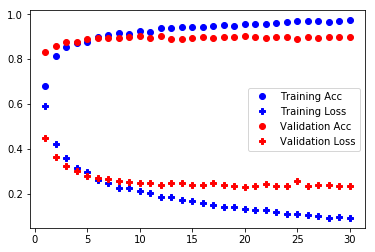

In [13]:
plot(history.history)

In [14]:
model.evaluate(test_features, test_labels)

1000/1000 [==============================] - 0s 119us/step


[0.25987913346290586, 0.882]